## Preprocessing


### Read files - assign labels - encode labels

In [84]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Directory where the data files are stored
data_folder = '../data'

def read_file(file_path):
    # Open and read the data from a file
    with open(file_path, 'r') as file:
         data_str = file.read()
    # Remove brackets and commas, then convert text to a list of floats
    data_str_filtered = data_str.translate(str.maketrans('', '', '[],'))
    data_list = [float(item) for item in data_str_filtered.split() if item]
    # Convert the list to a NumPy array and reshape it
    data_array = np.array(data_list)
    reshaped_data = np.array(data_array.reshape(140, 61, 1))
    return reshaped_data

def assign_label(file_name):
    # Assign labels based on the file name
    if 'bottle' in file_name: return 'Bottle'
    elif 'cap' in file_name: return 'Cap'
    elif 'wall' in file_name: return 'Wall'
    elif 'shoe' in file_name: return 'Shoe'    
    else: return 'Unknown'

# List to store data along with their labels
data_labels = []
# Collect all data for normalization
all_data = []

### Read and preprocess each file in the data directory
for file_name in os.listdir(data_folder):
    file_path = os.path.join(data_folder, file_name)
    
    # Check if the file name is "shoe1.txt" and skip it
    if file_name == 'shoe1.txt':
        continue
    
    if os.path.isfile(file_path):
        # Read and preprocess the data file
        content = read_file(file_path)
        # Collect data for finding the global maximum value
        all_data.append(content)
        # Assign label based on the file name
        label = assign_label(file_name)
        # Append the preprocessed data and its label to the list
        data_labels.append((content, label))

### Normalize the data
# First, concatenate all data to find the global maximum
all_data_np = np.concatenate(all_data, axis=0)
# Find the maximum value across all data for normalization
global_max = np.max(all_data_np)

# Normalize each piece of data by the global maximum
normalized_data_labels = [(content/global_max, label) for content, label in data_labels]

# Split the normalized data and labels for training and testing
X, y = zip(*normalized_data_labels)
# Initialize and fit the label encoder to convert labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded)

# Shuffle the data and labels together to maintain correspondence
X_shuffled, y_shuffled = shuffle(X, y_encoded, random_state=42)### Split the dataset into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=42)

# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Print the sizes of the training and test sets
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)


Shape of X_train:  (89, 140, 61, 1)
Shape of y_train:  (89, 3)


## Vizualization

IndexError: arrays used as indices must be of integer (or boolean) type

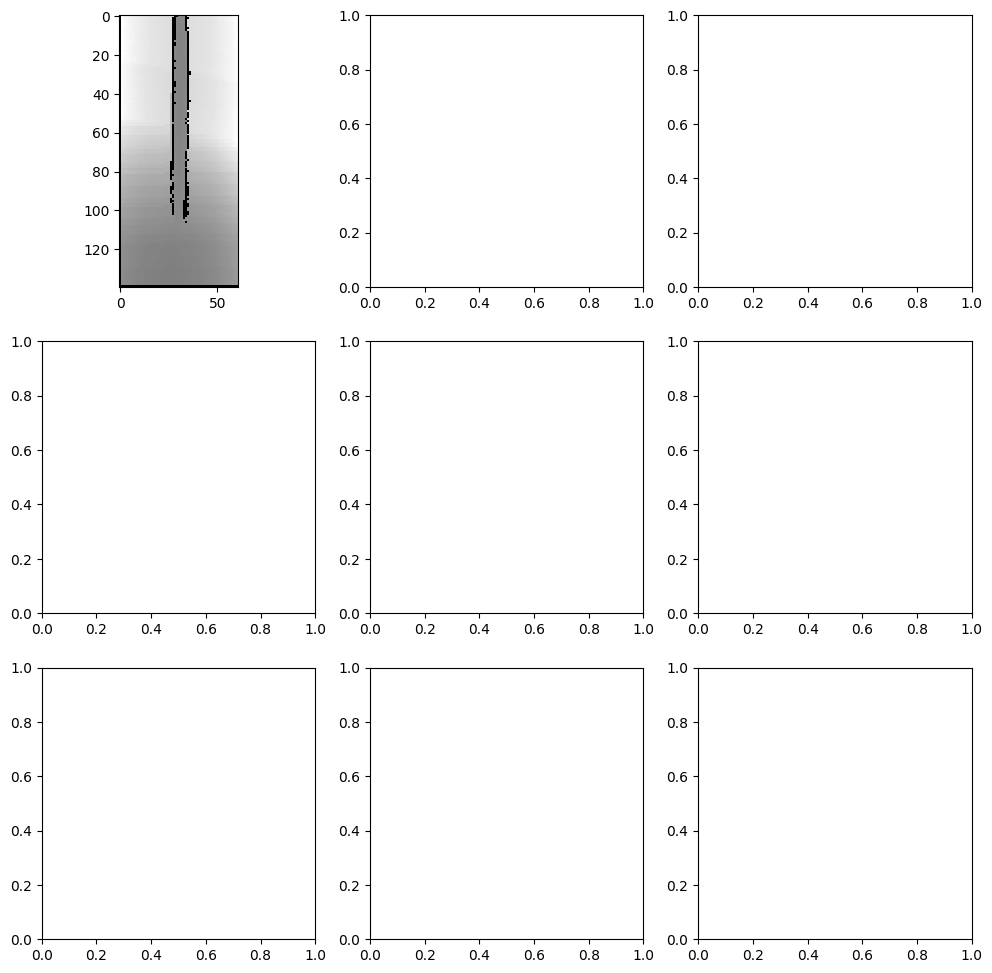

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'X' is your images array and 'y_encoded' are your numerically encoded labels
unique_classes = np.unique(y_encoded)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # Set up a 3x3 grid
axes = axes.flatten()  # Flatten the axes array for easier use

for i, cls in enumerate(unique_classes):
    cls_indices = np.where(y_encoded == cls)[0][:3]  # Get first 3 indices of each class
    for j, idx in enumerate(cls_indices):
        if i*3+j >= 9:  # Stop after filling the 3x3 grid
            break
        image = X[idx]  # Replace this with actual image fetching logic
        # Preprocess the image as needed
        clipped_array = np.clip(image, None, 1000)
        flipped_array = np.flipud(clipped_array)

        axes[i*3+j].imshow(flipped_array, cmap='gray', interpolation='nearest')
        axes[i*3+j].set_title(f'Class {label_encoder.inverse_transform([cls])[0]} Image {j+1}')
        axes[i*3+j].axis('off')  # Hide axis ticks

plt.tight_layout()
plt.show()

In [130]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def get_model():
    
    height = 140
    width = 61

    model = Sequential([
        Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(height, width, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(3, activation='softmax')  # Three classes for classification
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    #model.summary()

    return model

#fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=1)
get_model().summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_124 (Conv2D)         (None, 140, 61, 16)       160       
                                                                 
 max_pooling2d_124 (MaxPool  (None, 70, 30, 16)        0         
 ing2D)                                                          
                                                                 
 conv2d_125 (Conv2D)         (None, 70, 30, 32)        4640      
                                                                 
 max_pooling2d_125 (MaxPool  (None, 35, 15, 32)        0         
 ing2D)                                                          
                                                                 
 flatten_53 (Flatten)        (None, 16800)             0         
                                                                 
 dense_106 (Dense)           (None, 64)              

In [122]:
get_model().fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
3/3 [==============================] - 1s 107ms/step - loss: 1.0932 - accuracy: 0.3708 - val_loss: 1.0818 - val_accuracy: 0.4348
Epoch 2/100
3/3 [==============================] - 0s 38ms/step - loss: 1.0575 - accuracy: 0.4944 - val_loss: 1.0457 - val_accuracy: 0.3913
Epoch 3/100
3/3 [==============================] - 0s 40ms/step - loss: 0.9980 - accuracy: 0.4270 - val_loss: 1.0120 - val_accuracy: 0.3913
Epoch 4/100
3/3 [==============================] - 0s 39ms/step - loss: 0.9041 - accuracy: 0.5056 - val_loss: 1.1244 - val_accuracy: 0.4348
Epoch 5/100
3/3 [==============================] - 0s 39ms/step - loss: 0.9556 - accuracy: 0.5056 - val_loss: 1.1395 - val_accuracy: 0.5217
Epoch 6/100
3/3 [==============================] - 0s 42ms/step - loss: 0.9324 - accuracy: 0.4157 - val_loss: 1.0329 - val_accuracy: 0.4348
Epoch 7/100
3/3 [==============================] - 0s 42ms/step - loss: 0.8967 - accuracy: 0.4831 - val_loss: 0.9956 - val_accuracy: 0.4348
Epoch 8/100
3/3 [==

In [129]:
get_model().evaluate(X_test, y_test)

1/1 [==============================] - 0s 202ms/step - loss: 1.1006 - accuracy: 0.1739


[1.1006333827972412, 0.17391304671764374]

In [124]:
get_model().predict(X_test)

1/1 [==============================] - 0s 72ms/step


array([[0.33268422, 0.33347437, 0.33384138],
       [0.33224246, 0.33371356, 0.33404395],
       [0.33203262, 0.33413494, 0.33383244],
       [0.33287516, 0.33337465, 0.3337502 ],
       [0.33210874, 0.33420324, 0.33368808],
       [0.3321688 , 0.33385208, 0.33397916],
       [0.3327221 , 0.33297595, 0.33430195],
       [0.3327979 , 0.33378157, 0.33342052],
       [0.33245304, 0.33338916, 0.33415776],
       [0.33214456, 0.33487433, 0.3329811 ],
       [0.33239678, 0.33347502, 0.3341281 ],
       [0.33219254, 0.3337875 , 0.33401996],
       [0.33222312, 0.33390635, 0.33387056],
       [0.33199656, 0.33393586, 0.33406764],
       [0.33249265, 0.33370912, 0.33379823],
       [0.33297783, 0.3333296 , 0.33369258],
       [0.33218995, 0.333768  , 0.33404198],
       [0.33246934, 0.33370084, 0.3338298 ],
       [0.33285135, 0.33334786, 0.33380076],
       [0.33217728, 0.3337874 , 0.3340354 ],
       [0.33223668, 0.33384797, 0.3339154 ],
       [0.3323523 , 0.3336869 , 0.33396077],
       [0.